### Now it's time to test how the LBP (Local Binary Patterns) method works when extracting features from images.

In [50]:
from skimage.feature import local_binary_pattern
from skimage import io, color, feature
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns

pickle_file_path = './dataframe.pkl'
all_images_path = '../data/processed/all_images'
all_images = os.listdir(all_images_path)

In [2]:
def extract_lbp(imagepath, num_points, radius):
    rgb_image = cv2.imread(f"{all_images_path}/{imagepath}")
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    
    lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')
    (histogram, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points+3), range = (0, num_points+2))
    
    histogram = histogram.astype("float")
    return histogram

16384.0


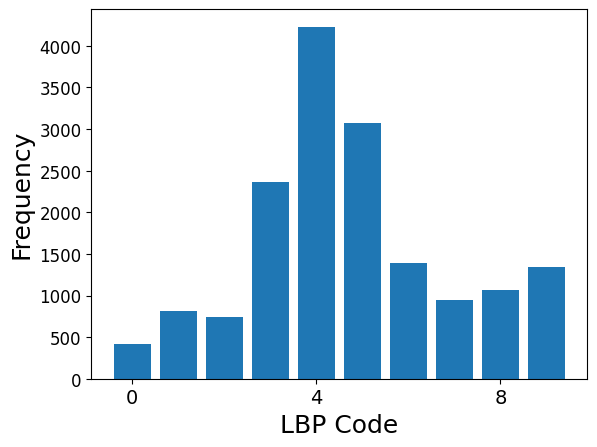

In [3]:
P = 8
R = 1
x = extract_lbp(all_images[3], P, R)
print(sum(x))
# Plot the histogram
plt.bar(np.arange(0, P+2), x, align='center')
plt.xlabel('LBP Code', fontsize=18)  # Adjust font size for x-axis label
plt.ylabel('Frequency', fontsize=18)  # Adjust font size for y-axis label
plt.xticks(np.arange(0, P+2, 4), fontsize=14)  # Adjust font size and x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size for y-axis ticks
plt.savefig('lbp_histogram_8_1.pdf', format='pdf', bbox_inches='tight')
plt.show()

16384.0


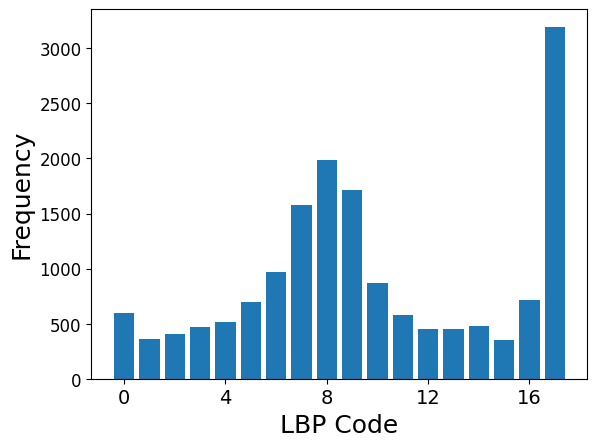

In [4]:
P = 16
R = 2
x = extract_lbp(all_images[3], P, R)
print(sum(x))
# Plot the histogram
plt.bar(np.arange(0, P+2), x, align='center')
plt.xlabel('LBP Code', fontsize=18)  # Adjust font size for x-axis label
plt.ylabel('Frequency', fontsize=18)  # Adjust font size for y-axis label
plt.xticks(np.arange(0, P+2, 4), fontsize=14)  # Adjust font size and x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size for y-axis ticks
plt.savefig('lbp_histogram_16_2.pdf', format='pdf', bbox_inches='tight')
plt.show()

16384.0


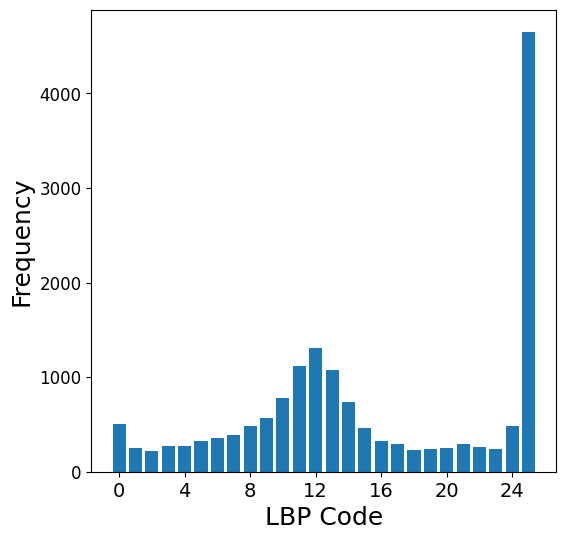

In [5]:
P = 24
R = 3
x = extract_lbp(all_images[3], P, R)
print(sum(x))
# Plot the histogram
plt.figure(figsize=(6, 6))  # Set figure size for the face image
plt.bar(np.arange(0, P+2), x, align='center')
plt.xlabel('LBP Code', fontsize=18)  # Adjust font size for x-axis label
plt.ylabel('Frequency', fontsize=18)  # Adjust font size for y-axis label
plt.xticks(np.arange(0, P+2, 4), fontsize=14)  # Adjust font size and x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size for y-axis ticks
plt.savefig('lbp_histogram_24_3.pdf', format='pdf', bbox_inches='tight')
plt.show()

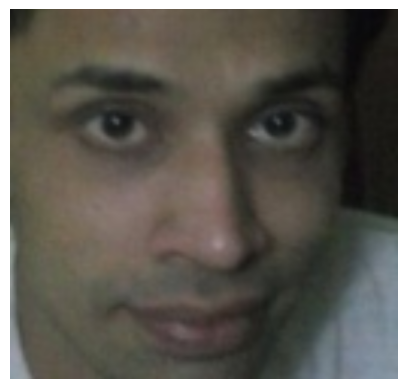

In [6]:
# Display the face image
face_image = cv2.imread(f"{all_images_path}/{all_images[3]}")
face_image_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(face_image_rgb, (566, 540))
plt.imshow(resized_image, cmap='gray')
plt.axis('off')  # Turn off axis labels and ticks
plt.savefig('face_image.pdf', format='pdf', bbox_inches='tight')
plt.show()

### After seeing how the LBP histogram looks, I will experiment with different normalisation techniques.
For this part, I will choose the number of points to be 16, the radius to be 2, and I will perform training and validation on the first fold of the 5 folds performed for HOG.

In [7]:
with open('dataframe.pkl', 'rb') as f:
    hog_df = pickle.load(f)

no_hog_df = hog_df.drop('hog_features', axis=1)

In [12]:
tqdm.pandas()
no_hog_df['lbp_p16_r2'] = no_hog_df['name'].progress_apply(lambda x: extract_lbp(x, 16, 2))
print(no_hog_df)

100%|██████████| 26851/26851 [03:12<00:00, 139.46it/s]

                              name  age  \
0                       000002.jpg   80   
1                       000003.jpg   50   
2                       000004.jpg   17   
3                       000005.jpg   27   
4                       000006.jpg   24   
...                            ...  ...   
26846  9_1_0_20170110224621441.jpg    9   
26847  9_1_0_20170117172655681.jpg    9   
26848  9_1_0_20170117180006484.jpg    9   
26849  9_1_1_20170109201837354.jpg    9   
26850  9_1_1_20170117105556810.jpg    9   

                                              lbp_p16_r2  
0      [703.0, 449.0, 606.0, 598.0, 482.0, 594.0, 793...  
1      [775.0, 548.0, 524.0, 472.0, 449.0, 593.0, 751...  
2      [537.0, 324.0, 421.0, 517.0, 451.0, 643.0, 100...  
3      [594.0, 365.0, 407.0, 473.0, 513.0, 693.0, 970...  
4      [235.0, 234.0, 262.0, 286.0, 381.0, 698.0, 107...  
...                                                  ...  
26846  [478.0, 291.0, 381.0, 399.0, 515.0, 753.0, 108...  
26847  [543

In [13]:
with open('./dataframe_lbp_16p_2r.pkl', 'wb') as f:
    pickle.dump(no_hog_df, f)

In [14]:
def normalise_histogram(histogram, method):
    if method == 'L1':
        # L1 normalization (sum of absolute values)
        norm_factor = np.sum(np.abs(histogram))
    elif method == 'L2':
        # L2 normalization (Euclidean norm)
        norm_factor = np.sqrt(np.sum(histogram ** 2))
    elif method == 'max':
        # Max normalization (divide by maximum value)
        norm_factor = np.max(histogram)
    elif method == 'sum':
        # Sum normalization (divide by sum of values)
        norm_factor = np.sum(histogram)
    else:
        norm_factor = np.sum(np.abs(histogram))

    return histogram / norm_factor

def get_class_dict(filename):
    with open(filename, "r") as f:
        class_dict = json.load(f)
    
    return class_dict

# Function that gets the label for an age, given a label dictionary
def get_class(age, class_dict):
    for label, age_interval in class_dict.items():
        if age >= age_interval[0] and age <= age_interval[1]:
            return label

    return -1

In [15]:
multilabel_dict = get_class_dict("age_intervals_one.json")

In [173]:
norms = ['L1', 'L2', 'max', 'sum']
norms_accuracies = []

for i in tqdm(range(len(norms))):
    norm = norms[i]
    cv_accuracies = []
    for j in range(5):
        # load the fold indices
        with open(f'./fold_data/fold_{j}.json', 'r') as f:
            fold_data = json.load(f)
        
        # get the train and validation folds
        X_fold_train = np.vstack(np.array([item for item in no_hog_df['lbp_p16_r2']])[fold_data['train']])
        y_fold_train = np.array([get_class(x, multilabel_dict) for x in no_hog_df['age']])[fold_data['train']]
        X_fold_val = np.vstack(np.array([item for item in no_hog_df['lbp_p16_r2']])[fold_data['val']])
        y_fold_val = np.array([get_class(x, multilabel_dict) for x in no_hog_df['age']])[fold_data['val']]
                
        # compute normalised LBP histograms
        X_fold_train_normalised = np.array([normalise_histogram(row, method=norm) for row in X_fold_train])
        X_fold_val_normalised = np.array([normalise_histogram(row, method=norm) for row in X_fold_val])
        print(f"Working for norm = {norm}")
        
        svm_classifier = SVC()
        svm_classifier.fit(X_fold_train_normalised, y_fold_train)
        predictions = svm_classifier.predict(X_fold_val_normalised)
        acc = accuracy_score(y_fold_val, predictions)
        cv_accuracies.append(acc)
    
    cv_acc = np.mean(cv_accuracies)
    print(f'CV Accuracy for norm = {norm} is: {cv_acc}')
    norms_accuracies.append((norm, cv_acc))

print(f'Therefore, best normalisation is: {sorted(norms_accuracies, reverse=True, key = lambda x: x[1])[0][0]}')

  0%|          | 0/4 [00:00<?, ?it/s]

Working for norm = L1
Working for norm = L1
Working for norm = L1
Working for norm = L1
Working for norm = L1


 25%|██▌       | 1/4 [01:54<05:43, 114.57s/it]

CV Accuracy for norm = L1 is: 0.44017690875232773
Working for norm = L2
Working for norm = L2
Working for norm = L2
Working for norm = L2
Working for norm = L2


 50%|█████     | 2/4 [03:50<03:50, 115.20s/it]

CV Accuracy for norm = L2 is: 0.4395251396648045
Working for norm = max
Working for norm = max
Working for norm = max
Working for norm = max
Working for norm = max


 75%|███████▌  | 3/4 [05:53<01:58, 118.83s/it]

CV Accuracy for norm = max is: 0.4400837988826815
Working for norm = sum
Working for norm = sum
Working for norm = sum
Working for norm = sum
Working for norm = sum


100%|██████████| 4/4 [08:14<00:00, 123.50s/it]

CV Accuracy for norm = sum is: 0.44017690875232773
Therefore, best normalisation is: L1


### Although there is no much difference in normalisations, sum normalisation and L1 norm perform the best (because all values are positive, so obviously). Therefore, I will choose the sum norm. Now onto the best choice for the number of points and radius.

In [16]:
p_r_pairs = [(8, 1), (16, 2)]
for i in tqdm(range(len(p_r_pairs))):
    p, r = p_r_pairs[i]
    with open('dataframe.pkl', 'rb') as f:
        hog_df = pickle.load(f)

    no_hog_df = hog_df.drop('hog_features', axis=1)
    no_hog_df[f'lbp_{p}p_{r}r'] = no_hog_df['name'].progress_apply(lambda x: extract_lbp(x, p, r))

    with open(f'./dataframe_lbp_{p}p_{r}r.pkl', 'wb') as f:
        pickle.dump(no_hog_df, f)
    

100%|██████████| 2/2 [04:54<00:00, 147.18s/it]


Now that all lbp features have been saved, we can go ahead and perform cross validation with a simple SVM classifier, on the 5 folds, to see which parameter setting is the best. Before fitting the SVM, we need to normalise the vectors using L1 norm, as stated previously.
\\
We will use the default SVC implementation.

In [17]:
lbp_prtweak_models = {}
best_norm = "L1"

for i in tqdm(range(len(p_r_pairs))):
    # get corresponding dataframe for given p and r values
    p, r = p_r_pairs[i]
    with open(f'./dataframe_lbp_{p}p_{r}r.pkl', 'rb') as f:
        df = pickle.load(f)
    
    cv_accuracies = []
    print(f'Currently working on LBP with p={p} and r={r}')

    # iterate through all 5 folds for CV
    for j in range(5):
        with open(f'./fold_data/fold_{j}.json') as f:
            fold_data = json.load(f)
        
        # get folds from indices
        X_fold_train = np.vstack(np.array([item for item in df[f'lbp_{p}p_{r}r']])[fold_data['train']])
        y_fold_train = np.array([get_class(x, multilabel_dict) for x in df['age']])[fold_data['train']]
        X_fold_val = np.vstack(np.array([item for item in df[f'lbp_{p}p_{r}r']])[fold_data['val']])
        y_fold_val = np.array([get_class(x, multilabel_dict) for x in df['age']])[fold_data['val']]

        # normalise LBP vectors
        X_fold_train_normalised = np.array([normalise_histogram(row, method=best_norm) for row in X_fold_train])
        X_fold_val_normalised = np.array([normalise_histogram(row, method=best_norm) for row in X_fold_val])

        # fit SVM and find accuracy
        svm_classifier = SVC()
        svm_classifier.fit(X_fold_train_normalised, y_fold_train)
        predictions = svm_classifier.predict(X_fold_val_normalised)
        acc = accuracy_score(y_fold_val, predictions)
        cv_accuracies.append(acc)
        print(f'Accuracy for fold={j} is: {acc}.')
    
    cv_accuracy = np.mean(cv_accuracies)
    lbp_prtweak_models[f'Model_{i*5+j}'] = {'p': p, 'r':r, 'cv_accuracy': cv_accuracy}
    
    

  0%|          | 0/2 [00:00<?, ?it/s]

Currently working on LBP with p=8 and r=1
Accuracy for fold=0 is: 0.4136405959031657.
Accuracy for fold=1 is: 0.43854748603351956.
Accuracy for fold=2 is: 0.430633147113594.
Accuracy for fold=3 is: 0.42481378026070765.


 50%|█████     | 1/2 [01:41<01:41, 101.07s/it]

Accuracy for fold=4 is: 0.44297020484171323.
Currently working on LBP with p=16 and r=2
Accuracy for fold=0 is: 0.42202048417132215.
Accuracy for fold=1 is: 0.4436685288640596.
Accuracy for fold=2 is: 0.44273743016759776.
Accuracy for fold=3 is: 0.438780260707635.


100%|██████████| 2/2 [03:35<00:00, 107.79s/it]

Accuracy for fold=4 is: 0.4536778398510242.


In [18]:
with open('lbp_models_cv_pandr.json', 'w') as f:
    json.dump(lbp_prtweak_models, f, indent=4)

In [19]:
best_parameter_setting = [[model, lbp_prtweak_models[model]['cv_accuracy']] for model in lbp_prtweak_models]
best_parameter_setting = sorted(best_parameter_setting, key=lambda x: x[1], reverse=True)[0][0]
best_parameter_setting = (best_parameter_setting, lbp_prtweak_models[best_parameter_setting]['p'], 
                          lbp_prtweak_models[best_parameter_setting]['r'], 
                          lbp_prtweak_models[best_parameter_setting]['cv_accuracy'])

print(best_parameter_setting)

('Model_9', 16, 2, 0.44017690875232773)


### Therefore, the best model has p=16 and r=2. Now onto hyperparameter tuning for the SVM model. As for HOG, I will be tuning C value and the kernel.

In [ ]:
best_p, best_r = best_parameter_setting[1:-1]
kernels = ['rbf', 'linear', 'poly']
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
os.makedirs('lbp_models', exist_ok=True)
model_folder = './lbp_models'

with open(f'./dataframe_lbp_{best_p}p_{best_r}r.pkl', 'rb') as f:
    df = pickle.load(f)

for C in C_values:
    for kernel in kernels:
        print(f'Currently computing CV accuracy for C={C} and kernel={kernel}.')
        cv_accuracies = []
        model_name = f'Model_C={C}_kernel={kernel}'
        
        for i in range(5):
            with open(f'./fold_data/fold_{i}.json') as f:
                fold_data = json.load(f)
            
            # get folds from indices
            X_fold_train = np.vstack(np.array([item for item in df[f'lbp_{best_p}p_{best_r}r']])[fold_data['train']])
            y_fold_train = np.array([get_class(x, multilabel_dict) for x in df['age']])[fold_data['train']]
            X_fold_val = np.vstack(np.array([item for item in df[f'lbp_{best_p}p_{best_r}r']])[fold_data['val']])
            y_fold_val = np.array([get_class(x, multilabel_dict) for x in df['age']])[fold_data['val']]

            # normalise LBP vectors
            X_fold_train_normalised = np.array([normalise_histogram(row, method=best_norm) for row in X_fold_train])
            X_fold_val_normalised = np.array([normalise_histogram(row, method=best_norm) for row in X_fold_val])

            # fit SVM and find accuracy
            svm_classifier = SVC(C=C, kernel=kernel)
            svm_classifier.fit(X_fold_train_normalised, y_fold_train)
            predictions = svm_classifier.predict(X_fold_val_normalised)
            acc = accuracy_score(y_fold_val, predictions)
            cv_accuracies.append(acc)

            report = classification_report(y_fold_val, predictions)
            with open(f"{model_folder}/{model_name}_classification_report_fold_{i}.txt", 'w') as f:
                f.write(report)

            print(f'Accuracy for fold={i} is: {acc}.')
        
        cv_accuracy = np.mean(cv_accuracies)

        print(f'CV Accuracy for model={model_name} is: {cv_accuracy}')

        with open(f"{model_folder}/{model_name}.pkl", 'wb') as f:
            pickle.dump(svm_classifier, f)

        with open(f"{model_folder}/cv_accuracies.txt", 'a') as f:
             f.write(f"{model_name}_CVaccuracy={cv_accuracy}\n")

            

### Finding best performing three models.

In [27]:
all_models = {}
with open('./lbp_models/cv_accuracies.txt', 'r') as f:
    j = 0
    for line in f.readlines():
        temp = line.strip()
        _, C_value, kernel, cv_acc = temp.split('_')
        C_value = C_value.split('=')[1]
        kernel = kernel.split('=')[1]
        cv_acc = cv_acc.split('=')[1]
        all_models[j] = {'C': C_value, 'kernel': kernel, 'cv_accuracy': cv_acc}
        j += 1

sorted_models = sorted(all_models.items(), key=lambda x: float(x[1]['cv_accuracy']), reverse=True)[:3]

print(sorted_models)

[(18, {'C': '1000', 'kernel': 'rbf', 'cv_accuracy': '0.4527932960893855'}), (20, {'C': '1000', 'kernel': 'poly', 'cv_accuracy': '0.450512104283054'}), (15, {'C': '100', 'kernel': 'rbf', 'cv_accuracy': '0.4482774674115456'})]


In [29]:
with open(f'./dataframe_lbp_16p_2r.pkl', 'rb') as f:
    lbp_df = pickle.load(f)

In [32]:
with open('initial_splits_binary.json', 'r') as f:
    fold_data = json.load(f)

X_train = np.vstack(np.array([item for item in lbp_df['lbp_16p_2r']])[fold_data['train']])
y_train = np.array([get_class(x, multilabel_dict) for x in lbp_df['age']])[fold_data['train']]
X_test = np.vstack(np.array([item for item in lbp_df['lbp_16p_2r']])[fold_data['test']])
y_test = np.array([get_class(x, multilabel_dict) for x in lbp_df['age']])[fold_data['test']]

In [34]:
# normalise LBP vectors
X_train_normalised = np.array([normalise_histogram(row, method='L1') for row in X_train])
X_test_normalised = np.array([normalise_histogram(row, method='L1') for row in X_test])

### Testing model 1.

In [37]:
svm_classifier = SVC(C=1000, kernel='rbf', random_state=42)
svm_classifier.fit(X_train_normalised, y_train)
predictions = svm_classifier.predict(X_test_normalised)
report = classification_report(y_test, predictions)
print(f'Final test metrics are: \n')
print(report)

Final test metrics are: 

              precision    recall  f1-score   support

           0       0.60      0.01      0.03       414
           1       0.36      0.15      0.21      1140
           2       0.41      0.87      0.56      1852
           3       0.25      0.03      0.06       888
           4       0.32      0.27      0.29       690
           5       0.45      0.33      0.38       387

    accuracy                           0.39      5371
   macro avg       0.40      0.28      0.25      5371
weighted avg       0.38      0.39      0.31      5371



In [38]:
cm = confusion_matrix(y_test, predictions)
recall = recall_score(y_test, predictions, average = 'weighted')
precision = precision_score(y_test, predictions, average = 'weighted')
f1 = f1_score(y_test, predictions, average = 'weighted')
test_acc = accuracy_score(y_test, predictions)

In [39]:
print("Confusion Matrix:")
print(cm)

print("\nWeighted Recall:", recall)
print("Weighted Precision:", precision)
print("Weighted F1 Score:", f1)
print("Test Accuracy:", test_acc)

Confusion Matrix:
[[   6  127  241    6   26    8]
 [   1  171  889   11   51   17]
 [   3  108 1602   25   91   23]
 [   0   38  686   28  105   31]
 [   0   20  380   29  186   75]
 [   0    6  119   15  120  127]]

Weighted Recall: 0.3947123440700056
Weighted Precision: 0.378938682932171
Weighted F1 Score: 0.3130696844538562
Test Accuracy: 0.3947123440700056


In [40]:
def calculate_one_off_accuracy(confusion_matrix):
    one_off_correct = 0
    total_samples = np.sum(confusion_matrix)

    # Iterate through the confusion matrix
    for i in range(len(confusion_matrix)):
        # Main diagonal
        one_off_correct += confusion_matrix[i][i]

        # Adjacent diagonals
        if i > 0:
            one_off_correct += confusion_matrix[i][i - 1]  # Element on the left
        if i < len(confusion_matrix) - 1:
            one_off_correct += confusion_matrix[i][i + 1]  # Element on the right

    one_off_accuracy = one_off_correct / total_samples
    return one_off_accuracy

one_off_accuracy = calculate_one_off_accuracy(cm)
print("Entire One-off Accuracy:", one_off_accuracy)

Entire One-off Accuracy: 0.7978030161981009


### Testing Model 2.

In [41]:
svm_classifier_two = SVC(C=1000, kernel='poly', random_state=42)
svm_classifier_two.fit(X_train_normalised, y_train)
predictions = svm_classifier_two.predict(X_test_normalised)
report = classification_report(y_test, predictions)
print(f'Final test metrics are: \n')
print(report)

Final test metrics are: 

              precision    recall  f1-score   support

           0       0.44      0.01      0.02       414
           1       0.36      0.14      0.20      1140
           2       0.40      0.88      0.55      1852
           3       0.27      0.03      0.05       888
           4       0.33      0.26      0.29       690
           5       0.48      0.32      0.39       387

    accuracy                           0.39      5371
   macro avg       0.38      0.27      0.25      5371
weighted avg       0.37      0.39      0.31      5371



In [42]:
cm = confusion_matrix(y_test, predictions)
recall = recall_score(y_test, predictions, average = 'weighted')
precision = precision_score(y_test, predictions, average = 'weighted')
f1 = f1_score(y_test, predictions, average = 'weighted')
test_acc = accuracy_score(y_test, predictions)

In [45]:
print("Confusion Matrix:")
print(cm)

print("\nWeighted Recall:", recall)
print("Weighted Precision:", precision)
print("Weighted F1 Score:", f1)
print("Test Accuracy:", test_acc)

Confusion Matrix:
[[   4  115  262    4   21    8]
 [   2  156  914    9   46   13]
 [   1   98 1626   23   85   19]
 [   0   38  713   23   86   28]
 [   2   25  404   18  176   65]
 [   0    5  131    8  118  125]]

Weighted Recall: 0.3928504933904301
Weighted Precision: 0.3706112930693986
Weighted F1 Score: 0.30619269527430415
Test Accuracy: 0.3928504933904301


In [43]:
one_off_accuracy = calculate_one_off_accuracy(cm)
print("Entire One-off Accuracy:", one_off_accuracy)

Entire One-off Accuracy: 0.7935207596350773


### Testing Model 3.

In [46]:
svm_classifier_three = SVC(C=100, kernel='rbf', random_state=42)
svm_classifier_three.fit(X_train_normalised, y_train)
predictions = svm_classifier_three.predict(X_test_normalised)
report = classification_report(y_test, predictions)
print(f'Final test metrics are: \n')
print(report)

Final test metrics are: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       414
           1       0.36      0.12      0.18      1140
           2       0.40      0.88      0.55      1852
           3       0.25      0.03      0.05       888
           4       0.32      0.26      0.29       690
           5       0.47      0.33      0.39       387

    accuracy                           0.39      5371
   macro avg       0.30      0.27      0.24      5371
weighted avg       0.33      0.39      0.30      5371



In [47]:
cm = confusion_matrix(y_test, predictions)
recall = recall_score(y_test, predictions, average = 'weighted')
precision = precision_score(y_test, predictions, average = 'weighted')
f1 = f1_score(y_test, predictions, average = 'weighted')
test_acc = accuracy_score(y_test, predictions)

In [48]:
print("Confusion Matrix:")
print(cm)

print("\nWeighted Recall:", recall)
print("Weighted Precision:", precision)
print("Weighted F1 Score:", f1)
print("Test Accuracy:", test_acc)

Confusion Matrix:
[[   0  110  265    8   21   10]
 [   0  141  919    9   55   16]
 [   1   80 1633   26   91   21]
 [   0   34  703   25  100   26]
 [   0   23  397   20  179   71]
 [   0    3  129   11  116  128]]

Weighted Recall: 0.3921057531185999
Weighted Precision: 0.33228662166084855
Weighted F1 Score: 0.30313571138577905
Test Accuracy: 0.3921057531185999


In [49]:
one_off_accuracy = calculate_one_off_accuracy(cm)
print("Entire One-off Accuracy:", one_off_accuracy)

Entire One-off Accuracy: 0.7914727238875442


In [53]:
classes = ['6-15', '16-25', '26-35', '36-50', '51-65', '66-120']
preds = svm_classifier.predict(X_test_normalised)
cm = confusion_matrix(y_test, preds)

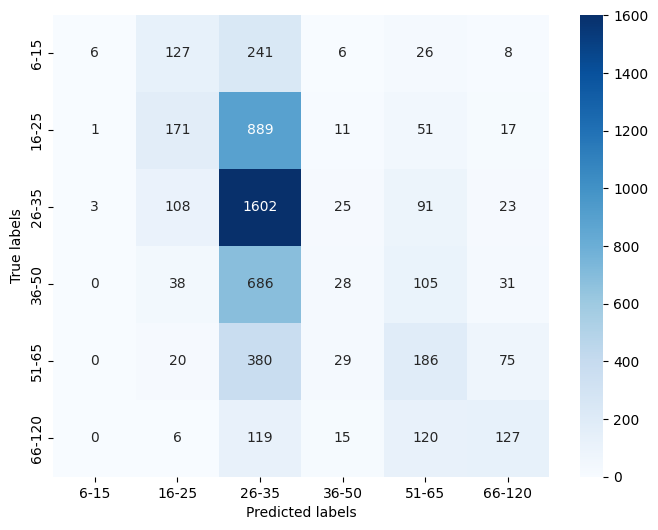

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.savefig('confusion_matrix_lbp.pdf', format='pdf')
plt.show()

In [56]:
print(cm)
print(preds)

[[   6  127  241    6   26    8]
 [   1  171  889   11   51   17]
 [   3  108 1602   25   91   23]
 [   0   38  686   28  105   31]
 [   0   20  380   29  186   75]
 [   0    6  119   15  120  127]]
['2' '2' '2' ... '4' '5' '2']


In [65]:
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

# Calculate class weights
class_weights = np.sum(cm, axis=1) / np.sum(cm)

# Calculate weighted Precision, Recall, and F1-score
weighted_precision = np.sum(precision * class_weights)
weighted_recall = np.sum(recall * class_weights)
weighted_f1_score = np.sum(f1 * class_weights)

# Print results
print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1-score:", weighted_f1_score)

Weighted Precision: 0.37893868293217103
Weighted Recall: 0.39471234407000555
Weighted F1-score: 0.31306968445385625


In [69]:
recall = recall_score(y_test, preds, average = 'weighted')
precision = precision_score(y_test, preds, average = 'weighted')
print(precision)

0.378938682932171
